Goal - improve model performance with feature engineering.

Two new feautures added: distance from the center of Manhattan and distance from the high crime spot. Result: the regression metrics (MSE, R2, ...) are slightly improved.

One-hot encoding used for neighbourhood_group and room_type.

Additionally, a new binary feature 'expensive_nh' added, indicating whether a neighbourhood belongs to a list of the 10 most expensive Manhattan neighbourhoods.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import matplotlib.pyplot as plt

import seaborn as sns

from sodapy import Socrata

from shapely.geometry import Point, Polygon
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import mapclassify as mc
import scipy.ndimage as ndimage

from geopy import distance

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import eli5

/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Dataset

In [50]:
df = pd.read_csv('./AB_NYC_2019.csv')

In [51]:
df.shape

(48895, 16)

In [52]:
df.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [53]:
df = df.drop(['id', 'name', 'host_id', 'host_name'], axis=1)

In [54]:
df.isna().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

# Target - price

In [55]:
df.price[df.price<=0]

23161    0
25433    0
25634    0
25753    0
25778    0
25794    0
25795    0
25796    0
26259    0
26841    0
26866    0
Name: price, dtype: int64

Very few entries with price = 0, simply drop them:

In [56]:
df = df[df.price > 0]

<AxesSubplot:>

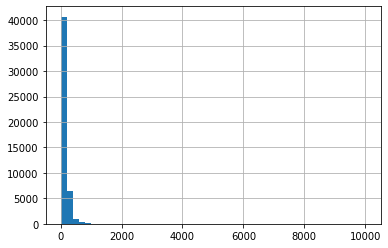

In [57]:
df.price.hist(bins=50)

log the target to make it look more normal 

In [58]:
df.price[df.price > 1000]

496      2000
762      1300
946      3000
1105     1300
1480     2000
         ... 
48080    1308
48304    2999
48305    1999
48523    1369
48535    1749
Name: price, Length: 239, dtype: int64

Have 239 rates above 1000, put them to 1000

In [59]:
def price_ceiling(price):
    if price > 1000:
        price = 1000
    return price

In [60]:
df.price = df.price.apply(price_ceiling)

<AxesSubplot:>

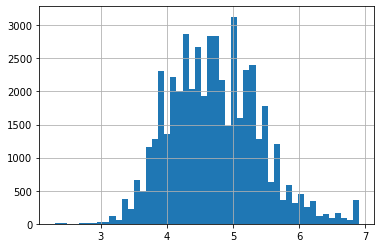

In [61]:
df.price.apply(lambda x: np.log(x)).hist(bins=50)

In [62]:
df['log_price'] = df.price.apply(lambda x: np.log(x))

# neighbourhood group

In [63]:
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

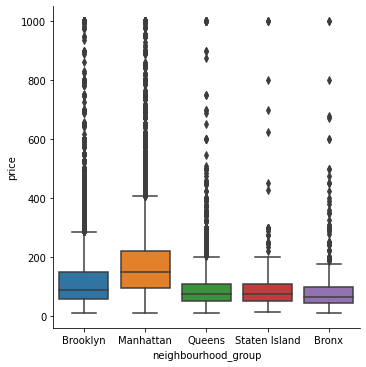

In [64]:
sns.catplot(x="neighbourhood_group", y="price", kind="box", data=df)

In [65]:
df_hood_means = df.pivot_table(index=['neighbourhood_group'],
                        values=['price','minimum_nights', 'availability_365'],
                        aggfunc=[np.mean],
                        margins=True) 

In [66]:
df_hood_means

mean                           
                    availability_365 minimum_nights       price
neighbourhood_group                                            
Bronx                     165.794495       4.563303   86.200917
Brooklyn                  100.217318       6.055486  120.231351
Manhattan                 111.984580       8.579409  185.464543
Queens                    144.451818       5.181433   96.605542
Staten Island             199.678284       4.831099  103.418231
All                       112.779498       7.029887  145.510024

One hot encoding for neighbourhood_group

In [67]:
df = pd.get_dummies(df, prefix='hood_group', columns=['neighbourhood_group'], drop_first=True)

# neighbourhood

There are many neighbourhoods, makes no sense to dummy-encode them all.
They are already geographically grouped in the neighbourhood_group column.
Idea: create new feauture indicating most expensive neighbourhoods.

In [68]:
#https://www.investopedia.com/articles/personal-finance/092515/most-expensive-neighborhoods-manhattan.asp
expensive_manh_neighborhoods = ['SoHo', 'Tribeca', 'Flatiron District', 
                                'Midtown Manhattan', 'Hudson Square', 'West Village',
                                'Garment District', 'Central Park South']

In [69]:
mask_ = df.neighbourhood.apply(lambda x: x in expensive_manh_neighborhoods)

In [70]:
df['expensive_nh_new'] = np.where(mask_, 1, 0)

In [71]:
df['expensive_nh_new'].value_counts()

0    47501
1     1383
Name: expensive_nh_new, dtype: int64

# room type

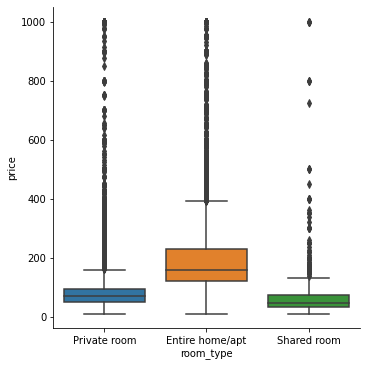

In [72]:
sns.catplot(x="room_type", y="price", kind="box", data=df)

In [73]:
df = pd.get_dummies(df, prefix='room_type', columns=['room_type'], drop_first=True)

In [77]:
df.columns

Index(['neighbourhood', 'latitude', 'longitude', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'log_price',
       'hood_group_Brooklyn', 'hood_group_Manhattan', 'hood_group_Queens',
       'hood_group_Staten Island', 'expensive_nh_new',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

# Reviews per month

In [145]:
len(df[df['number_of_reviews']== 0]['reviews_per_month'])

10051

In [146]:
df['reviews_per_month'].fillna(0, inplace=True)

# Selected correlations

<AxesSubplot:>

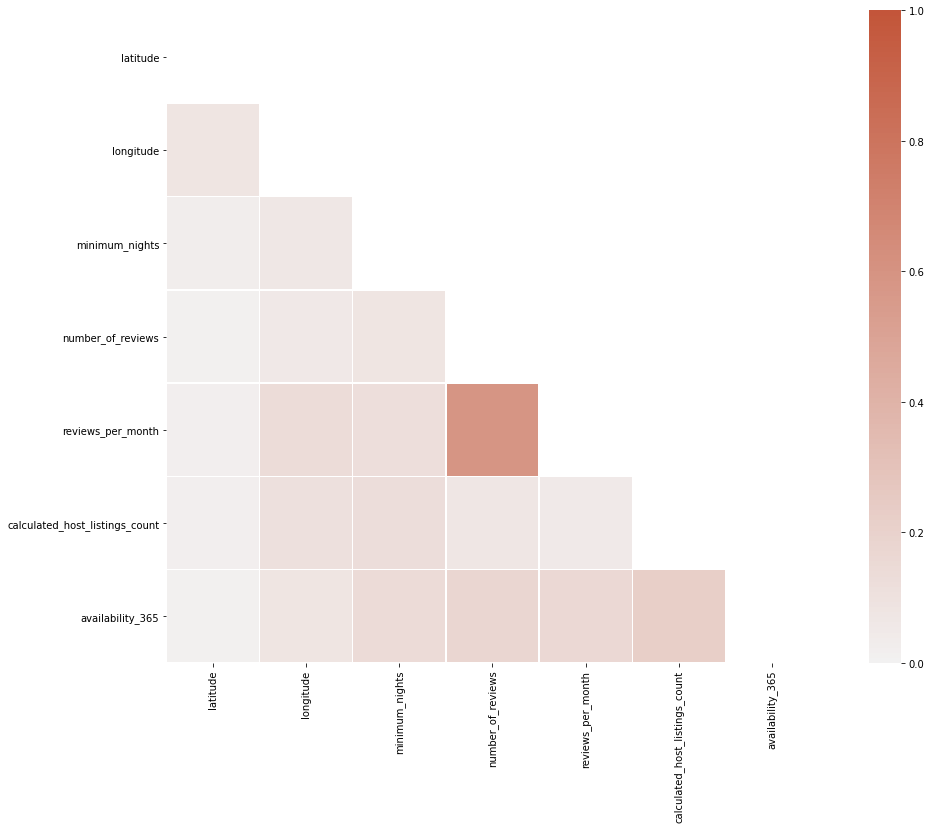

In [152]:
# Compute the correlation matrix
corr = df[['neighbourhood', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']].corr().abs()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0, center=0.0,
            square=True, linewidths=.5)

# Price geo visuals

In [80]:
rent_geo_df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [81]:
rent_geo_df.head(3)

neighbourhood  latitude  longitude  price  minimum_nights  \
0    Kensington  40.64749  -73.97237    149               1   
1       Midtown  40.75362  -73.98377    225               1   
2        Harlem  40.80902  -73.94190    150               3   

   number_of_reviews last_review  reviews_per_month  \
0                  9  2018-10-19               0.21   
1                 45  2019-05-21               0.38   
2                  0         NaN               0.00   

   calculated_host_listings_count  availability_365  log_price  \
0                               6               365   5.003946   
1                               2               355   5.416100   
2                               1               365   5.010635   

   hood_group_Brooklyn  hood_group_Manhattan  hood_group_Queens  \
0                    1                     0                  0   
1                    0                     1                  0   
2                    0                     1                  0   

   hood_group_Staten Island  expensive_nh_new  room_type_Private room  \
0                         0                 0                       1   
1                         0                 0                       0   
2                         0                 0                       1   

   room_type_Shared room                    geometry  
0                      0  POINT (-73.97237 40.64749)  
1                      0  POINT (-73.98377 40.75362)  
2                      0  POINT (-73.94190 40.80902)

In [82]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

In [83]:
scheme_rent_price = mc.Quantiles(rent_geo_df['price'], k=25)

In [84]:
scheme_rent_price

Quantiles                 

     Interval        Count
--------------------------
[  10.00,   39.00] |  2031
(  39.00,   45.00] |  2172
(  45.00,   50.00] |  2347
(  50.00,   55.00] |  1407
(  55.00,   60.00] |  2095
(  60.00,   67.00] |  1776
(  67.00,   72.00] |  1886
(  72.00,   79.00] |  2101
(  79.00,   85.00] |  2409
(  85.00,   90.00] |  1663
(  90.00,   99.00] |  1979
(  99.00,  100.00] |  2051
( 100.00,  110.00] |  1531
( 110.00,  120.00] |  2094
( 120.00,  130.00] |  2149
( 130.00,  145.00] |  1823
( 145.00,  150.00] |  2432
( 150.00,  165.00] |  1416
( 165.00,  180.00] |  2082
( 180.00,  200.00] |  3056
( 200.00,  220.00] |   800
( 220.00,  250.00] |  2376
( 250.00,  300.00] |  1851
( 300.00,  400.00] |  1594
( 400.00, 1000.00] |  1763

<GeoAxesSubplot:>

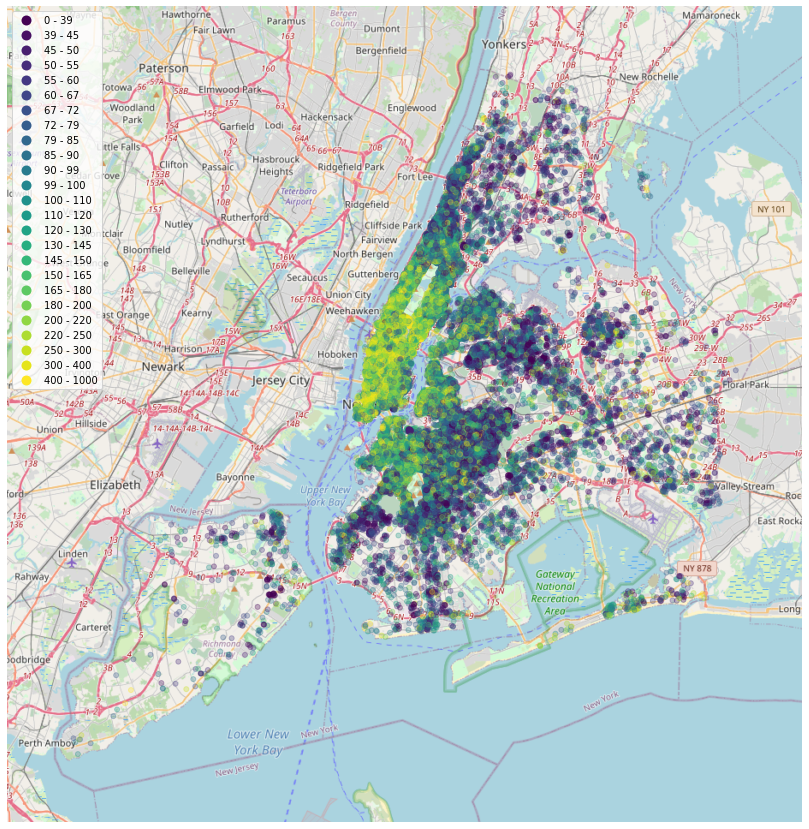

In [85]:
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(), figsize=(15,15))

gplt.pointplot(
    rent_geo_df,
    hue=rent_geo_df.price,
    ax = ax,
    alpha=0.3,
    scheme=scheme_rent_price,
    legend=True
)

#### Same data, different graphical representation

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

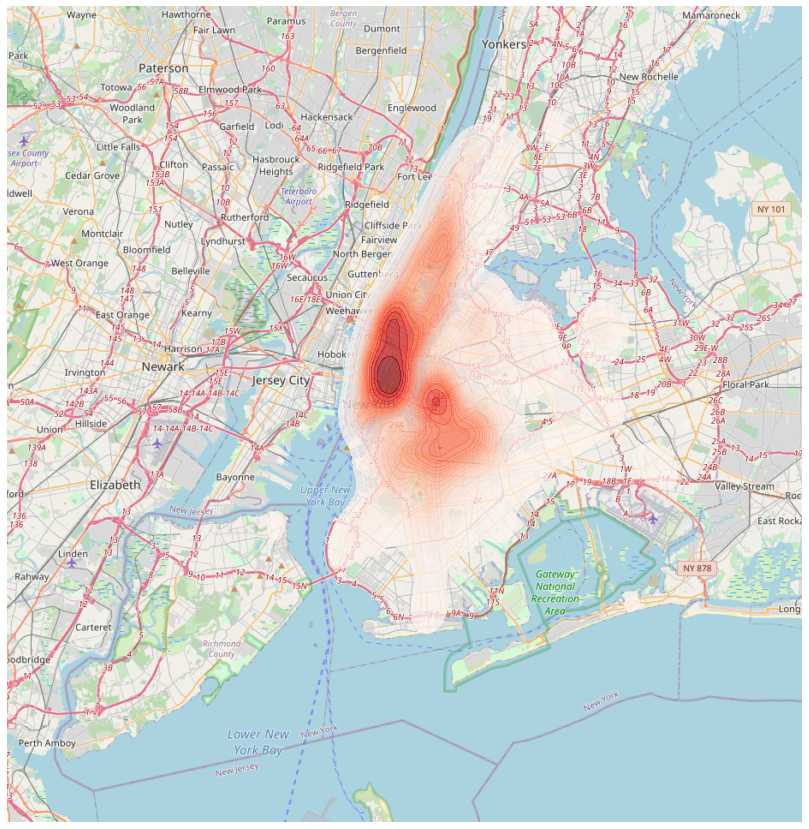

In [86]:
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(), figsize=(15,15))

gplt.kdeplot(
    rent_geo_df,
    weights=rent_geo_df.price,
    ax=ax, 
    cmap='Reds', 
    shade=True,
    n_levels=20,
    alpha=0.7
)

# High crime regions visuals

In [87]:
#crime statistics from
#https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc
client = Socrata("data.cityofnewyork.us", None)
Results = client.get("uip8-fykc", limit=100000)
crime_df = pd.DataFrame.from_records(Results)

In [88]:
crime_df = crime_df.astype({'latitude': 'float64'})
crime_df = crime_df.astype({'longitude': 'float64'})
crime_geo_df = gpd.GeoDataFrame(
    crime_df, geometry=gpd.points_from_xy(crime_df.longitude, crime_df.latitude))

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.5`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

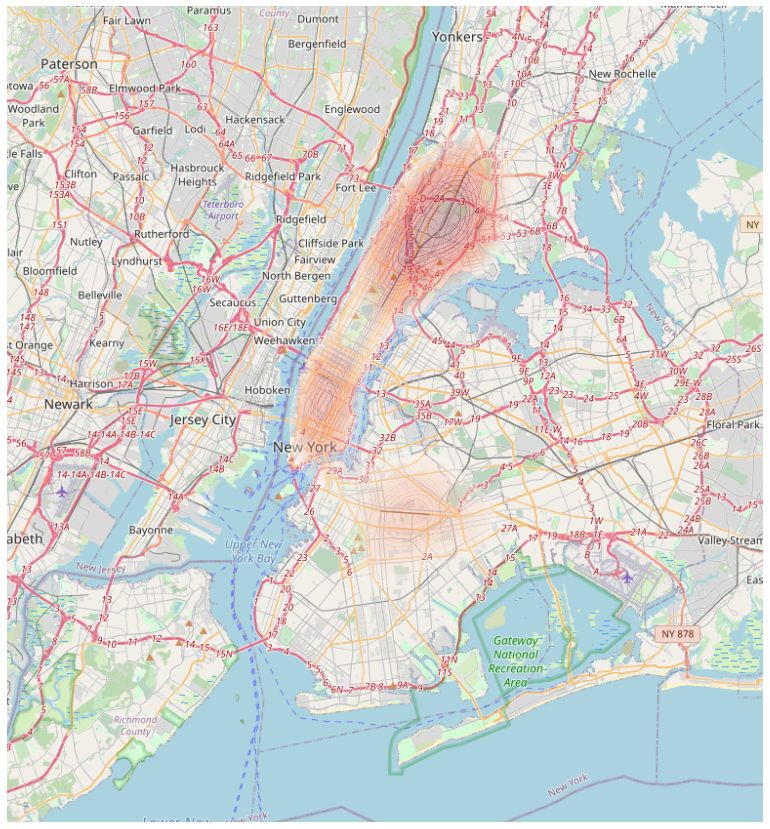

In [89]:
#robbery in 2020 heat map
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(),figsize=(15,15))
gplt.kdeplot(crime_geo_df[crime_geo_df.ofns_desc=='ROBBERY'], 
             ax=ax, 
             cmap='Reds', 
             shade=True,
             thresh=0.5,
             n_levels=30,
             alpha=0.25)

# New geo features

In [90]:
MANHATTAN_CENTER_COORDS = (40.741366, -73.987816)
HIGH_CRIME_COORDS = (40.833332, -73.902501)

In [91]:
def dist_from_point(df, point_coords):    
    return distance.distance(point_coords, (df.latitude, df.longitude)).km

In [92]:
df['dist_from_manh'] = df.apply(dist_from_point, axis = 1, args=(MANHATTAN_CENTER_COORDS,))
df['dist_from_crime'] = df.apply(dist_from_point, axis = 1, args=(HIGH_CRIME_COORDS,))

# Model building

In [96]:
y = df.loc[:, df.columns == 'log_price']

In [97]:
y

log_price
0       5.003946
1       5.416100
2       5.010635
3       4.488636
4       4.382027
...          ...
48890   4.248495
48891   3.688879
48892   4.744932
48893   4.007333
48894   4.499810

[48884 rows x 1 columns]

In [98]:
features_ = ['latitude',
             'longitude',
             'number_of_reviews', 
             'reviews_per_month',
             'minimum_nights',
             'availability_365',
             'room_type_Private room',
             'room_type_Shared room',
             'hood_group_Staten Island',
             'hood_group_Brooklyn',
             'hood_group_Manhattan',
             'hood_group_Queens',
             ]

features_enhanced_ = ['dist_from_manh', 'dist_from_crime'] + features_ + ['expensive_nh_new']

X = df[features_]
X_enhanced = df[features_enhanced_]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y, test_size = 0.3)

In [107]:
X_train.head()

latitude  longitude  number_of_reviews  reviews_per_month  \
6508   40.78635  -73.97616                 16               0.29   
19472  40.67764  -73.92241                  5               0.15   
23031  40.76848  -73.93213                 27               1.03   
8621   40.78602  -73.97729                133               2.80   
30062  40.63012  -74.13512                  0               0.00   

       minimum_nights  availability_365  room_type_Private room  \
6508               30               271                       0   
19472               3               145                       1   
23031               3               154                       1   
8621                2               155                       1   
30062              31                 0                       0   

       room_type_Shared room  hood_group_Staten Island  hood_group_Brooklyn  \
6508                       0                         0                    0   
19472                      0                         0                    1   
23031                      0                         0                    0   
8621                       0                         0                    0   
30062                      0                         1                    0   

       hood_group_Manhattan  hood_group_Queens  
6508                      1                  0  
19472                     0                  0  
23031                     0                  1  
8621                      1                  0  
30062                     0                  0

In [115]:
scaler = StandardScaler()
scaler.fit(X_train.iloc[:,:6])
scaler.transform(X_train.iloc[:,:6])
scaler.transform(X_test.iloc[:,:6])

array([[-1.21445332e+00,  4.13561978e+00,  3.68992777e+00,
         2.51620973e+00, -2.46463343e-01,  1.80952385e+00],
       [-1.51195976e+00,  2.91343281e-02,  1.34645361e+00,
         8.79843013e-01, -9.88467657e-02, -6.23324507e-01],
       [-1.24534397e+00, -2.13076499e-01,  1.05351934e+00,
         4.36400124e-01, -2.95668868e-01, -8.58272479e-01],
       ...,
       [-7.07914653e-04, -5.61050545e-01,  7.83118480e-01,
        -2.69361094e-01,  1.13129138e+00,  6.57520890e-01],
       [-7.56793522e-01,  5.24196457e-02, -5.23819029e-01,
        -6.81575611e-01,  1.08208585e+00, -8.58272479e-01],
       [-5.83769067e-01,  8.32804216e-01, -5.23819029e-01,
        -6.81575611e-01, -9.88467657e-02, -8.58272479e-01]])

In [116]:
scaler = StandardScaler()
scaler.fit(X_train_enh.iloc[:,:8])
scaler.transform(X_train_enh.iloc[:,:8])
scaler.transform(X_test_enh.iloc[:,:8])

array([[-0.56022222,  0.63739562, -0.39114221, ...,  0.41356761,
        -0.24503383,  1.77722117],
       [ 0.64647743, -1.77621679,  1.64798631, ...,  1.07488415,
        -0.14716788,  0.75901046],
       [-1.22508557, -0.32217801,  0.44898461, ..., -0.65951206,
        -0.24503383, -0.85189008],
       ...,
       [-0.99644401,  0.22941406, -0.15280966, ..., -0.67822856,
        -0.2939668 , -0.85189008],
       [-0.01494412, -1.07626394,  0.71080182, ..., -0.44739166,
        -0.24503383,  1.04015819],
       [-0.1193048 , -1.05968208,  0.71410435, ..., -0.67822856,
        -0.2939668 , -0.85189008]])

In [117]:
class BaselineModel():
    def __init__(self, estimator='median'):
        self.pred = 0.0
        self.estimator = 'median'
    def fit(self, X, y):
        if self.estimator == 'median':
            self.pred = np.median(y)
        elif self.estimator == 'mean':
            self.pred = np.mean(y)
    def predict(self, X):
        shape_ = (len(X), 1)
        return np.full(shape=shape_, fill_value=self.pred)

In [180]:
def calc_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean( np.abs( (y_true - y_pred)/y_true ) )

metrics = {
           'MSE': mean_squared_error,
           'MAE': mean_absolute_error,
           'MAPE': calc_mape,
           'R2': r2_score
          }

def get_metrics(y_true, y_pred):
    output = {}
    for mname, metric in metrics.items():
        print(mname, metric(y_true, y_pred))
        output[mname] = metric(y_true, y_pred)
    return output

# Models w/o new features

In [183]:
results_default = {}

In [184]:
models = {
          'naive': BaselineModel(),
          'ridge': RidgeCV(),
          'lasso': LassoCV(),
          'elnet': ElasticNetCV(),
         }

In [185]:
for key, model in models.items():
    print(key)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = get_metrics(y_test, y_pred)
    results_default[key] = res

naive
MSE 0.4771400053223387
MAE 0.5504053984242971
MAPE 0.11697305486456576
R2 -0.012517902540213788
ridge
MSE 0.2351389691610393
MAE 0.36001480876778064
MAPE 0.07613943237610464
R2 0.5010218946123297
lasso


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE 0.24857253556646922
MAE 0.37237461903455593
MAPE 0.14037476275170555
R2 0.4725151118468146
elnet


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE 0.25332112927928296
MAE 0.3756252932611302
MAPE 0.13843211882003012
R2 0.4624383291572859


In [186]:
results_default

{'naive': {'MSE': 0.4771400053223387,
  'MAE': 0.5504053984242971,
  'MAPE': 0.11697305486456576,
  'R2': -0.012517902540213788},
 'ridge': {'MSE': 0.2351389691610393,
  'MAE': 0.36001480876778064,
  'MAPE': 0.07613943237610464,
  'R2': 0.5010218946123297},
 'lasso': {'MSE': 0.24857253556646922,
  'MAE': 0.37237461903455593,
  'MAPE': 0.14037476275170555,
  'R2': 0.4725151118468146},
 'elnet': {'MSE': 0.25332112927928296,
  'MAE': 0.3756252932611302,
  'MAPE': 0.13843211882003012,
  'R2': 0.4624383291572859}}

In [169]:
eli5.explain_weights(models['lasso'],feature_names=features_)

Explanation(estimator='LassoCV()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=4.9077095183577955, std=None, value=None), FeatureWeight(feature='hood_group_Manhattan', weight=0.3213536498958587, std=None, value=None), FeatureWeight(feature='availability_365', weight=0.0006219331230615678, std=None, value=None)], neg=[FeatureWeight(feature='room_type_Shared room', weight=-0.8263936559050367, std=None, value=None), FeatureWeight(feature='room_type_Private room', weight=-0.7390748919631333, std=None, value=None), FeatureWeight(feature='hood_group_Queens', weight=-0.054099939412477704, std=None, value=None), FeatureWeight(feature='reviews_per_month', weight=-0.008640955264897887, std=None, value=None), FeatureWeight(feature='minimum_nights', weight=-0.0017260663701929957, std=None, value=None), FeatureWeight(feature='number_of_reviews', weight=-0.0005807277877320926, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [170]:
eli5.show_weights(models['ridge'],feature_names=features_)

In [171]:
eli5.show_weights(models['elnet'],feature_names=features_)

# Models with the new engineered features

In [213]:
results_enhanced = {}

In [214]:
models_enh = {
              'naive': BaselineModel(),
              'ridge': RidgeCV(),
              'lasso': LassoCV(),
              'elnet': ElasticNetCV(),
             }

In [215]:
for key, model in models_enh.items():
    print(key)
    model.fit(X_train_enh, y_train_enh)
    y_pred = model.predict(X_test_enh)
    res = get_metrics(y_test_enh, y_pred)
    results_enhanced[key] = res

naive
MSE 0.4731837146485657
MAE 0.5499418708206283
MAPE 0.11767597315293601
R2 -0.006804645272144194
ridge
MSE 0.21716023069480894
MAE 0.3442373844836587
MAPE 0.07291737029893362
R2 0.537942827989575
lasso


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE 0.2275241864259505
MAE 0.35223476026390643
MAPE 0.14271181431868585
R2 0.5158911840921137
elnet


/usr/local/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MSE 0.23352537646298677
MAE 0.35593166190037073
MAPE 0.14126522674885308
R2 0.5031223042270565


In [228]:
eli5.show_weights(models_enh['lasso'],feature_names=features_enhanced_, top=None)

In [226]:
eli5.explain_weights(models_enh['ridge'],feature_names=features_enhanced_, top=None)

Explanation(estimator='RidgeCV(alphas=array([ 0.1,  1. , 10. ]))', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='latitude', weight=5.348099272135448, std=None, value=None), FeatureWeight(feature='longitude', weight=0.21240221021617872, std=None, value=None), FeatureWeight(feature='hood_group_Manhattan', weight=0.21055829804947868, std=None, value=None), FeatureWeight(feature='expensive_nh_new', weight=0.10804452393095995, std=None, value=None), FeatureWeight(feature='dist_from_crime', weight=0.060466651202279786, std=None, value=None), FeatureWeight(feature='hood_group_Queens', weight=0.05722380954101758, std=None, value=None), FeatureWeight(feature='hood_group_Brooklyn', weight=0.030556344408124048, std=None, value=None), FeatureWeight(feature='availability_365', weight=0.0007340238917095121, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-197.68988318615496, std=None, value=None), FeatureWeight(feature='room_type_Shared room', weight=-1.0844903000277015, std=None, value=None), FeatureWeight(feature='room_type_Private room', weight=-0.7300856986352349, std=None, value=None), FeatureWeight(feature='hood_group_Staten Island', weight=-0.08993407845525787, std=None, value=None), FeatureWeight(feature='dist_from_manh', weight=-0.04615900496266789, std=None, value=None), FeatureWeight(feature='reviews_per_month', weight=-0.003171378179954054, std=None, value=None), FeatureWeight(feature='minimum_nights', weight=-0.002132042601310502, std=None, value=None), FeatureWeight(feature='number_of_reviews', weight=-0.0005753188268613485, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [225]:
eli5.explain_weights(models_enh['elnet'],feature_names=features_enhanced_, top=None)

Explanation(estimator='ElasticNetCV()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=5.068064411278683, std=None, value=None), FeatureWeight(feature='hood_group_Manhattan', weight=0.19493366969055084, std=None, value=None), FeatureWeight(feature='dist_from_crime', weight=0.009274727809591984, std=None, value=None), FeatureWeight(feature='availability_365', weight=0.0007061456690521508, std=None, value=None)], neg=[FeatureWeight(feature='room_type_Private room', weight=-0.6581553397755993, std=None, value=None), FeatureWeight(feature='room_type_Shared room', weight=-0.5024663704142891, std=None, value=None), FeatureWeight(feature='dist_from_manh', weight=-0.04218960076039107, std=None, value=None), FeatureWeight(feature='hood_group_Brooklyn', weight=-0.029210709152593935, std=None, value=None), FeatureWeight(feature='minimum_nights', weight=-0.0018811541097310466, std=None, value=None), FeatureWeight(feature='number_of_reviews', weight=-0.0006055795722578086, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

# Comparision tables

Final result: comparing the default model and the model with added features

In [222]:
result_df_def = df.from_dict(results_default)
result_df_enh = df.from_dict(results_enhanced)

In [223]:
result_df_def

naive     ridge     lasso     elnet
MSE   0.477140  0.235139  0.248573  0.253321
MAE   0.550405  0.360015  0.372375  0.375625
MAPE  0.116973  0.076139  0.140375  0.138432
R2   -0.012518  0.501022  0.472515  0.462438

In [224]:
result_df_enh

naive     ridge     lasso     elnet
MSE   0.473184  0.217160  0.227524  0.233525
MAE   0.549942  0.344237  0.352235  0.355932
MAPE  0.117676  0.072917  0.142712  0.141265
R2   -0.006805  0.537943  0.515891  0.503122

Conclusion: engineered features improve the model.